# Getting started with Pyseter

Pyseter is an Python package for sorting images by an automatically generated ID. The main functions of Pyseter are:

1. Extracting features from images
2. Clustering images by proposed ID
3. Sorting images by cluster
4. Grading images by distinctiveness

This notebook will walk you through each major function. First, let's make sure that pyseter is properly installed, and that it can access Pytorch.  

In [1]:
import pyseter

pyseter.verify_pytorch()

✓ PyTorch 2.7.0 detected
✓ Apple Silicon (MPS) GPU available


If you're on a Mac, you should see something like

```
✓ PyTorch 2.7.0 detected
✓ Apple Silicon (MPS) GPU available
```

Please note, however, that *AnyDorsal* consumes quite a bit of memory. As such, only Apple Silicon devices with 16 GB or more of memory will work. Ideally, future versions of Pyseter will use a smaller model.

If neither Apple Silicon or an NVIDIA GPU are available, you will see a message like this.

```
✓ PyTorch 2.7.1+cu126 detected
! No GPU acceleration available. Expect slow feature extraction.
```

**A note for R users** In R, the above code block would look something like

```
library(pyseter)
verify_pytorch()
```

or, 

```
pyseter::verify_pytorch()
```

Imports work a little differently in Python. First, we need tell Python that this package is available for imports, `import pyseter`, then we need to explicitly call the function from the library `pyseter.verify_pytorch()`. To an R user, this can feel overly wordy. Nevertheless, this wordiness helps keep the global environment clean. Whereas R sessions frequently have to deal with [masking names](https://adv-r.hadley.nz/functions.html?q=masking#lexical-scoping), this rarely happens in Python. 

## Optional: Folder management

The main purpose of pyseter is organizing images into folders. To do keep things clean and tidy, we recommend establishing a `working directory` with a subfolder, e.g., called, `all images`, that contains every image you want to be sorted (see below for a different case). Optionally, you might want to have a .csv with encounter information in the working directory. This .csv would contain two columns: one for the image name, i.e., every image in `all images`, and another for the encounter. As such, the working directory would look like this. 

```
working directory
├── encounter_info.csv
├── all images
│   └──00cef32dc62b0f.jpg
│   └──3ecc025ea6f9bf.jpg
│   └──9f18762a48696b.jpg
│   └──36f78517a512dd.jpg
│   └──470d524b4d5303.jpg
       ...
│   └──4511c9e5cb7acb.jpg
```

Sometimes, you might have your images organized into subfolders by encounter. 

```
working_dir
└── original_images
    ├── SL_HI_006_20220616 (CROPPED)
    │   ├── 2022-06-16_CLD500_CL_006.JPG
    │   ├── 2022-06-16_CLD500_CL_007.JPG
    │   ├── 2022-06-16_CLD500_CL_008.JPG
    │   ├── 2022-06-16_CLD500_CL_021.JPG
    │   ├── 2022-06-16_CLD500_CL_042.JPG
...
    ├── SL_HI_007_20220616 (CROPPED)
    │   ├── 2022-06-16_CLD500_CL_346.JPG
    │   ├── 2022-06-16_CLD500_CL_347.JPG
    │   ├── 2022-06-16_CLD500_CL_371.JPG
    │   ├── 2022-06-16_CLD500_CL_372.JPG
```

In this case, you might want to accomplish two tasks: move all these images to one folder, and create a .csv that indicates which image belongs to which encounter (i.e., a map from image to encounter). The `prep_images()` function does just that. 

In [5]:
from pyseter.sort import prep_images

# various directories we'll be working with
working_dir = '/Users/philtpatton/datasets/spinner/working_dir'
original_image_dir = working_dir + '/original_images'

# new directory containing every image
image_dir = working_dir + '/all_images'

prep_images(original_image_dir, all_img_dir=image_dir)

Copied 1364 images to: /Users/philtpatton/datasets/spinner/working_dir/all_images
Saved encounter information to: /Users/philtpatton/datasets/spinner/working_dir/original_images/encounter_info.csv


**A note for R users** In python, you can concatenate strings with the `+` operator. This is equivalent to `paste0(working_dir, '/original_images')` in R.   

**A note for R users** Packages in Python tend to be subdivided into modules based on their functions. In pyseter, the `sort` module contains functions for sorting files, including other forms of file management. 

## 1. Extracting features

Pyseter extracts *feature vectors* for every image with [AnyDorsal](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.14167), an algorithm for identifying whales and dolphins of many species. Feature vectors summarize three-dimensional images into one-dimensional vectors that are useful for the task at hand, in this case, individual identification. 

Before we extract the feature vectors, let's first create a subfolder within our working directory to save them in. This isn't necessary, yet keeps things tidy. 

In [6]:
import os

# in case you want to save the features after extracting them 
feature_dir = working_dir + '/features'
os.makedirs(feature_dir, exist_ok=True)


**A note for R users**  The module, `os`,  is part of Python's *standard library*. People often refer to R and its standard libraries as "base R." Base R includes the stats library, which provides the function `rnorm`. The `os` module has many functions for tinkering with your operating system. 

We will extract features with the `FeatureExtractor` class. To do so, we first need to initialize the class. This sets up important parameters, such as the `batch_size`, which is the number of images that will be processed in parallel. Larger batches should run faster, although your mileage may vary. If you specify too large of a batch, you may encounter an `OutOfMemoryError` (see below for an example). If you encounter this error, try specifying a larger batch size. If you encounter this error with a very small batch size (say, 2), you may need to resize your images. You can do this manually by reducing the file size in an image editing software, or [with Python](https://imagekit.io/blog/image-resizing-in-python/)

```
OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 5.81 GiB of which 9.06 MiB is free. Including non-PyTorch memory, this process has 5.76 GiB memory in use. Of the allocated memory 5.64 GiB is allocated by PyTorch, and 50.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
```

**A note for R users** Python error messages are comically long, putting CVS receipts to shame. This is because they show the entire traceback, i.e., this error caused this error caused this error, etc. To quickly diagnose the problem, scroll to the bottom of the message. Then, you can further dissect it by scrolling up.

The second parameter is the `model_path`, which is the full path to the *AnyDorsal* model weights. T0D0: We have to find somewhere to host these weights, and to get permission from Ted since they are a Happywhale product. 

In [ ]:
from pyseter.extract import FeatureExtractor

# specify the configuration for the extractor 
fe = FeatureExtractor(
    batch_size=4,
    model_path='/home/pattonp/ristwhales/ristwhales_model.pth'
)

Using device: cuda (NVIDIA H200 NVL)


Once we've initialize the class, we can use its associated methods (functions). In this case, the only one we are interested in is `extract()`, which extracts a feature vector for every image in a specified directory. This can take several minutes, so we typically save the results afterwards. 

**A note for R users** Classes and methods also exist in R, but operate more behind the scenes. For example, `x <- data.frame()` initializes an object of class data.frame, and `summary(x)` calls the summary method for data.frames. Python makes this relationship more explicit. For example, the equivalent (although nonsensical) Python code would be `x = data.frame()` and `x.summary()`. 

In [13]:
# import numpy as np

# # extract the features for the input directory then save them
# features = fe.extract(image_dir=image_dir)

# # this saves them as an numpy array
# out_path = feature_dir + '/features.npy'
# np.save(out_path, features)

import numpy as np
out_path = feature_dir + '/features.npy'
features = np.load(out_path, allow_pickle=True).item()

The object `features` is a dictionary, whose keys are the filenames and whose values are the feature vectors associated with each filename. This helps ensure that each image is associated with the correct feature vector. Nevertheless, it can be easier to work with actual numpy arrays. To do so, convert the keys to a list, then to a numpy array

In [17]:
filenames = np.array(list(features.keys()))
feature_array = np.array(list(features.values()))

**A note for R users** The R objects that Python's dictionary most resemble is the [named vector](https://adv-r.hadley.nz/vectors-chap.html?q=named%20vector#attr-names) or the [list](https://adv-r.hadley.nz/vectors-chap.html?q=named%20vector#lists). Like a list, dictionaries can hold different data types. Unlike a list, dictionaries have no order, and therefore cannot be integer indexed.

## 2. Clustering images by proposed ID

Pyseter comes with two algorithm's for clustering images by proposed ID. Network clustering works better for small datasets. To use network clustering, we first need to compute the similarity scores between each pair of images.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = cosine_similarity(feature_array)

This indicates how similar the individuals in each image are. 

Next, we can perform the clustering. Each cluster represents a proposed ID. To access the "cluster labels" (these are just integers representing the cluster), we can access the cluster_idx attribute, i.e, `results.cluster_idx`. 

In [22]:
from pyseter.sort import NetworkCluster, report_cluster_results

nc = NetworkCluster(match_threshold=0.55)
results = nc.cluster_images(similarity_scores)

Following clusters may contain false positives:
['ID_0013', 'ID_0033', 'ID_0040', 'ID_0060', 'ID_0078', 'ID_0085', 'ID_0109']


Network clustering has one major hyperparameter, namely, the `match_threshold`, which indicates whether two images should be grouped within a cluster. That is, if the similarity score between two images is above a certain threshold, we cluster them into a proposed ID. High thresholds mean that few images will be clustered together, creating many clusters. Very low thresholds mean that many images will be clustered together, creating few clusters. `report_cluster_results` produces a quick and dirty summary of the number of clusters created, and the size of the largest cluster (i.e., the number of images associated to the most photographed individual). This is a quick sanity check.

In [23]:
cluster_labels = results.cluster_idx
report_cluster_results(cluster_labels)

Found 243 clusters.
Largest cluster has 30 images.


You'll also note that `nc.cluster_images()` warns that some clusters may contain "false positives." False positive matches occur when two separate individuals fall under the same proposed ID. We can diagnose possible false positives by evaluating the network. In this case, the network consists of nodes (images) and edges, which represent connections between images. Two images are connected when they have a similarity score above the threshold. A blob of connected nodes (i.e., connected components) represents a proposed ID. 

Sometimes, the connected components look less like a blob and more like a barbell, where two sets of images have many connections amongst each other, yet these two blobs are only connected by one link. We suspect that such clusters contain false positives, i.e., two sets of images for two individuals connected by one spurious link. We can plot the networks of the suspicious clusters with `results.plot_suspicious()`.

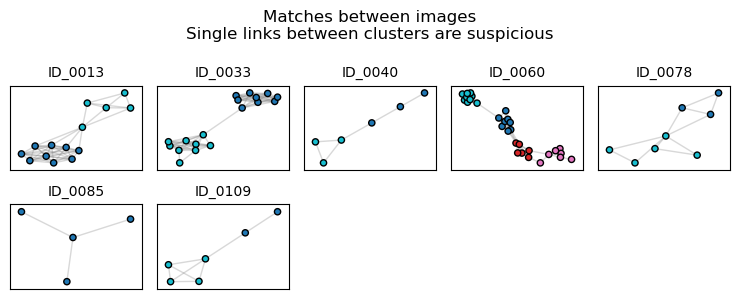

In [24]:
results.plot_suspicious()

`ID_0033` clearly has a barbell shape, suggesting that this cluster consists of images for two individuals linked together by one spurious connection.`ID_0013` also seems dubious, and `ID_0060` might consist of four separate individuals. 

Users can deal with suspicious clusters in several ways. First, raising the match threshold should reduce the number of false positive matches. That said, this will increase the *false negative rate*, whereby images of one individual are spread across multiple proposed IDs. Alternatively, users can manually inspect the images within the clusters and, if need be, divide up the images. 



The first is the HAC algorithm ([Hierarchical Agglomerative Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)), which works better for medium to large datasets (say, more than 2000 images). The other is 

In [7]:
from pyseter.sort import cluster_images, format_ids, report_cluster_results

# set up the configuration for the clustering algorithm
cluster_algorithm = 'network'
similarity_threshold = 0.6

# cluster away! 
results = cluster_images(feature_array, cluster_algorithm, similarity_threshold)
cluster_ids_hac = format_ids(results)

# quick summary of the clustering results
report_cluster_results(cluster_ids_hac)

ImportError: cannot import name 'cluster_images' from 'pyseter.sort' (/home/pattonp/.conda/envs/pyseter/lib/python3.13/site-packages/pyseter/sort.py)

In [24]:
from pyseter.sort import report_cluster_results

# quick summary of the clustering results
report_cluster_results(cluster_ids_hac)

Found 1276 clusters.
Largest cluster has 53 images.


In [28]:
# create a dataframe proposed id and encounter for each image
hac_df = pd.DataFrame({'image': bay1_filenames, 'autosort_id': cluster_ids_hac})
hac_df = hac_df.merge(bay1_encounter_info)

hac_df.head()

,image,autosort_id,encounter
0,IG_2024_04_25_G1_IMG_7800_1.jpg,ID-0485,IG_2024_04_25_G1
1,IG_2024_04_30_G1_IMG_6212_1.jpg,ID-0353,IG_2024_04_30_G1
2,IG_2025_03_26_G6_IMG_5982_1.jpg,ID-0009,IG_2025_03_26_G6
3,IG_2025_04_03_G2_IMG_2495_1.jpg,ID-0269,IG_2025_04_03_G2
4,IG_2024_05_07_G1_IMG_5733_1.jpg,ID-1132,IG_2024_05_07_G1


In [29]:
from pyseter.sort import sort_images

bay1_out = image_root + '/IG_autosort'
sort_images(hac_df, bay1_dir, bay1_out)

Sorted 7306 images into 2602 folders.


In [34]:
# we want to subdivide the clusters by encounter for easier viewing
bay2_encounter_info = pd.read_csv(image_root + '/SE_identifications.csv')
bay2_encounter_info.columns = ['image', 'encounter']

bay2_filenames = np.array(list(bay2_features.keys()))
bay2_feature_array = np.array(list(bay2_features.values()))

In [31]:
# cluster away! 
results = cluster_images(bay2_feature_array, cluster_algorithm, similarity_threshold)
cluster_ids_hac = format_ids(results)

# quick summary of the clustering results
report_cluster_results(cluster_ids_hac)

Clustering 6297 features with Hierachical Clustering.
Found 1005 clusters.
Largest cluster has 66 images.


In [35]:
# create a dataframe proposed id and encounter for each image
hac_df = pd.DataFrame({'image': bay2_filenames, 'autosort_id': cluster_ids_hac})
hac_df = hac_df.merge(bay2_encounter_info)

hac_df.head()

,image,autosort_id,encounter
0,SE_2025_04_28_G1_IMG_7314_1.jpg,ID-0071,SE_2025_04_28_G1
1,SE_2024_05_10_G3_IMG_6609_1.jpg,ID-0908,SE_2024_05_10_G3
2,SE_2024_04_22_G1_IMG_1275_3.jpg,ID-0924,SE_2024_04_22_G1
3,SE_2024_05_10_G1_IMG_4130_1.jpg,ID-0328,SE_2024_05_10_G1
4,SE_2025_04_28_G1_IMG_6897_1.jpg,ID-0021,SE_2025_04_28_G1


In [36]:
bay2_out = image_root + '/SE_autosort'
sort_images(hac_df, bay2_dir, bay2_out)

Sorted 6297 images into 2320 folders.
